In [1]:
# mute irrelevant messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.optimize import curve_fit
from scipy.stats import norm

# import required libraries 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random

from keras.initializers import RandomNormal
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU


In [2]:
# Define constants
# number of samples
sample_size= 1000
AB_steps = 1

lam = 1 # weight on mutual information 
mean_x = 0.0
sigma_x = 1.0


mean_nu = np.zeros(AB_steps+1)
sigma_nu = np.zeros(AB_steps+1)

mean_nu[0] = -0.8
sigma_nu[0] = np.sqrt(2.5)


# Defining Parameters and Loading Data:

INPUT_SHAPE = 1 # 1D samples
BATCH_SIZE = 512  
LATENT_DIM = 1 # 1D noise generator
SAMPLE_SIZE = sample_size * sample_size  # how many samples are used for training
DIM = 256  # Model dimensionality



# function used for fitting
def fit_func(x,mu,sigma):
    """gaussian function used for the fit"""
    return norm.pdf(x,loc=mu,scale=sigma)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               512       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 2

2023-07-18 12:36:04.402693: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
/home/ap45598/.local/lib/python3.8/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


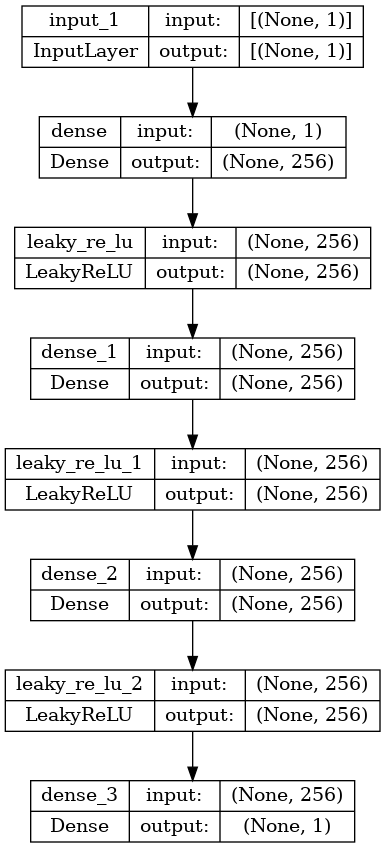

In [3]:
def define_generator(latent_dim=1):
    
    # weight initialization
    init = RandomNormal(stddev=0.02)
    
    # define model
    model = Sequential()
    
    model.add(tf.keras.Input(shape=(latent_dim,))) 
    
    # 1 to 512
    model.add(Dense(DIM, kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2))
    
    # 512 to 512
    model.add(Dense(DIM, kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2))
    
    # 512 to 512
    model.add(Dense(DIM, kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2))
    
    # 512 to 1 linearly
    model.add(Dense(1))
    
    return model

g_model = define_generator(LATENT_DIM)
g_model.summary()
keras.utils.plot_model(g_model, "g_model_with_shape_info.png", show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               512       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               65792     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               65792     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                

/home/ap45598/.local/lib/python3.8/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


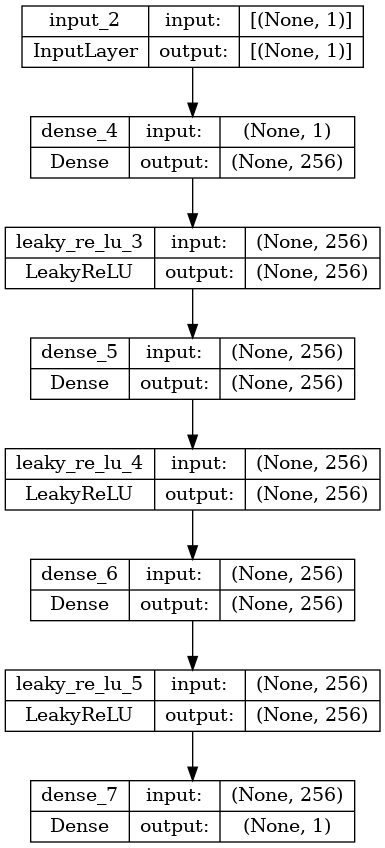

In [4]:
def define_critic(in_shape=1):
    
    # weight initialization
    init = RandomNormal(stddev=0.02)
    
    # define model
    model = Sequential()
    
    model.add(tf.keras.Input(shape=(in_shape,))) 

    # 1 to 512
    model.add(Dense(DIM, kernel_initializer=init)) #, input_dim=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    
    # 512 to 512
    model.add(Dense(DIM, kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2))
    
    # 512 to 512
    model.add(Dense(DIM, kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2))
    
    # 512 to 1 linearly
    model.add(Dense(1))
    
    return model

d_model = define_critic()
d_model.summary()
keras.utils.plot_model(d_model, "d_model_with_shape_info.png", show_shapes=True)

In [5]:
# Constructing overall GWAN

class WGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim, 
                 discriminator_extra_steps=5, gp_weight=0.1):
        super(WGAN, self).__init__()
        
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn
        
    # Gradient penalty 
    def gradient_penalty(self, batch_size, real_data, fake_data):
        # Get the interpolated data
        
        batch_size = tf.shape(real_data)[0]
        alpha = tf.random.uniform([batch_size,1], 0.0, 1.0)
        diff = fake_data - real_data
        interpolated = real_data + alpha * diff
        interpolated = real_data
        
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        #norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1]))
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[0]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    # Define train step
    def train_step(self, real_data):
        
        if isinstance(real_data, tuple):
            real_data = real_data[0]

        batch_size = tf.shape(real_data)[0]

        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_data = self.generator(random_latent_vectors, training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_data, training=True)
                # Get the logits for the real images
                real_logits = self.discriminator(real_data, training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.d_loss_fn(real_data=real_logits, fake_data=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_data, fake_data)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))
        
        # Train the generator
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_data = self.generator(random_latent_vectors, training=True)
            
            # Get the discriminator logits for fake images
            gen_data_logits = self.discriminator(generated_data, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_data_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))
        return {"d_loss": d_loss, "g_loss": g_loss}

In [6]:
# construct a monitor block
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_data=6, latent_dim=1):
        self.num_data = num_data
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_data, self.latent_dim))
        generated_data = self.model.generator(random_latent_vectors)

In [7]:
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

def discriminator_loss(real_data, fake_data):
    real_loss = tf.reduce_mean(real_data)
    fake_loss = tf.reduce_mean(fake_data)
    return fake_loss - real_loss

def generator_loss(fake_data):
    return -tf.reduce_mean(fake_data)

In [8]:
# generate data
for ii in range (AB_steps):
    
    REAL_DATA =[]
    weight=[]
    
    for jj in range(sample_size):
        
        sampled_x = np.random.normal(mean_x, sigma_x, 1) #generate one sample only
        sampled_u = np.random.normal(mean_nu[ii], sigma_nu[ii], sample_size)
    
        weight_batch = np.exp(-lam * (np.subtract(sampled_x, sampled_u)**2 ))
        weight_batch = weight_batch / np.sum(weight_batch)
        
        #print(sampled_x)
        #print(weight_batch)
    
        REAL_DATA =np.append(REAL_DATA , sampled_u)
        weight=np.append(weight, weight_batch)
        

REAL_DATA = np.array(REAL_DATA, dtype='float32')
#print(REAL_DATA.shape)

In [9]:
epochs = 20

# Instantiate the custom defined Keras callback.
cbk = GANMonitor(num_data=5, latent_dim = LATENT_DIM)

# Instantiate the WGAN model.
wgan = WGAN(discriminator=d_model,
            generator=g_model,
            latent_dim=LATENT_DIM,
            discriminator_extra_steps=5,)

# Compile the WGAN model.
wgan.compile(d_optimizer=discriminator_optimizer,
             g_optimizer=generator_optimizer,
             g_loss_fn=generator_loss,
             d_loss_fn=discriminator_loss,)

# Start training the model.
wgan.fit(REAL_DATA, batch_size = BATCH_SIZE, epochs=epochs, callbacks=[cbk])

#wgan.save_weights('path_to_my_weights_more_samples', save_format='tf')

Epoch 1/20
1954/1954 [==============================] - 77s 37ms/step - d_loss: -0.0049 - g_loss: -0.3514
Epoch 2/20
1954/1954 [==============================] - 75s 39ms/step - d_loss: -0.0025 - g_loss: -0.7964
Epoch 3/20
1954/1954 [==============================] - 78s 40ms/step - d_loss: -0.0025 - g_loss: -1.4592
Epoch 4/20
1954/1954 [==============================] - 79s 40ms/step - d_loss: -0.0021 - g_loss: -2.3834
Epoch 5/20
1954/1954 [==============================] - 79s 40ms/step - d_loss: -0.0020 - g_loss: -4.0972
Epoch 6/20
1954/1954 [==============================] - 79s 40ms/step - d_loss: -0.0019 - g_loss: -5.2573
Epoch 7/20
1954/1954 [==============================] - 79s 40ms/step - d_loss: -0.0018 - g_loss: -6.9144
Epoch 8/20
1954/1954 [==============================] - 79s 40ms/step - d_loss: -0.0018 - g_loss: -10.2046
Epoch 9/20
1954/1954 [==============================] - 79s 41ms/step - d_loss: -0.0016 - g_loss: -12.2229
Epoch 10/20
1954/1954 [=====================

Fitted mean =  -0.7932226952848032
Fitted covariance =  2.493065862139882


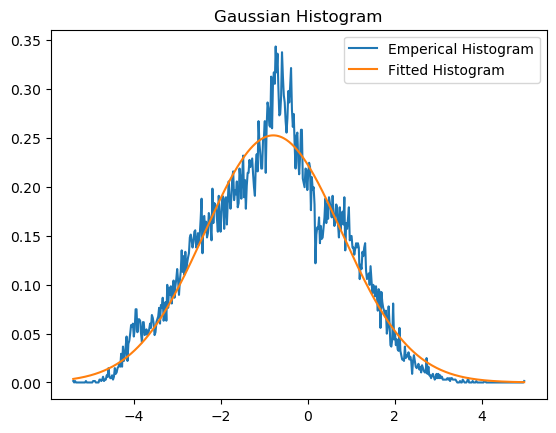

<Figure size 640x480 with 0 Axes>

In [11]:
# Generate outputs from trained network
random_latent_vec = tf.random.normal(shape=(1024 * 32, LATENT_DIM))
sample_data_tensor = wgan.generator(random_latent_vec)
sample_data_array = sample_data_tensor.numpy()

# compute and the histogram of samples
hist, bin_edges = np.histogram(sample_data_array, bins=500, density=True)#, weights=weight)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
    
#fit the histogram
coeff_0 = [0, 0.5] #starting values for the fit
coeff,_ = curve_fit(fit_func, bin_centers, hist, coeff_0, maxfev=10000)
    
# loging the new values of mean and sigma
# mean_nu[ii+1]=coeff[0]
# sigma_nu[ii+1]=coeff[1]
    
fig,ax = plt.subplots()

# compute and plot the histogram of samples
#hist, bin_edges = np.histogram(dataset, bins=500, density=True, weights=weight)
#bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
plt.plot(bin_centers, hist, label = 'Emperical Histogram')
  
# Get the fitted curve
hist_fit = fit_func(bin_centers, *coeff) 
plt.plot(bin_centers, hist_fit, label='Fitted Histogram')

# Finally, lets get the fitting parameters, i.e. the mean and standard deviation:
print ('Fitted mean = ', coeff[0])
print ('Fitted covariance = ', coeff[1]**2)    

plt.title("Gaussian Histogram") 

plt.legend()

plt.show()

plt.savefig('Generated_pdf2.png')
    

In [12]:
# # Create the critic model
# #d_model = define_critic(in_shape=1, dim=512)

# # Compile the model
# d_model.compile(optimizer='adam', loss='mean_squared_error')

# # Generate dummy data for training
# import numpy as np
# x_train = np.random.rand(1000, 1)
# y_train = np.random.rand(1000, 1)

# # Train the model for 10 epochs
# num_epochs = 10
# d_model.fit(x_train, y_train, epochs=num_epochs, batch_size=32)